In [14]:
import numpy as np #importing packages
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from dataset_tools import MNIST
from plotting import loss_plots

from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

False


# Data

In [2]:
flatten = lambda x: ToTensor()(x).view(-1)

# data_train = MNIST(train=True, transform=ToTensor())
# data_test = MNIST(train=False, transform=ToTensor())
data_train = MNIST(train=True, transform=flatten)
data_test = MNIST(train=False, transform=flatten)

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True, pin_memory=cuda)



In [3]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 784]) torch.Size([64])


# VAE

In [4]:

# input img -> hidden -> mu, logvar -> reparameterization trick (sample point from distribution made from mu, logvar) -> decoder -> output img
class VAE(nn.Module):
    """
    Variational Autoencoder
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # latent space
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.sigma = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        # q(z|x)
        h = self.encoder(x) # hidden
        mu = self.mu(h) # mean
        sigma = self.sigma(h) # log variance
        return mu, sigma # mean and log variance
    
    def decode(self, z):
        # p(x|z)
        return self.decoder(z)

    def reparameterize(self, mu, sigma):
        if self.training:
            eps = torch.randn_like(sigma)
            return mu + eps * sigma
        else:
            return mu

    def forward(self, x):

        mu, sigma = self.encode(x) 
        z = self.reparameterize(mu, sigma) # sample z from q(z|x) = mu + std * eps
        x_hat = self.decoder(z) # reconstruct x from z p(x|z)
        return x_hat, mu, sigma




In [5]:
model = VAE(input_dim=28*28, hidden_dim=256, latent_dim=2)
print(model)
if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
bceloss = nn.BCELoss(reduction='sum')

def loss_function(x, x_hat, mu, sigma, beta=1.0):
    # BCE = F.binary_cross_entropy(x_hat, x, reduction='sum')
    MSE = F.mse_loss(x_hat, x, reduction='sum')
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # kullback-leibler divergence between q(z|x) and p(z)
    KLD = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
    # return {"BCE": BCE, "KLD": KLD, "loss": BCE + beta * KLD}
    return {"MSE": MSE, "KLD": KLD, "loss": MSE + beta * KLD}





VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (sigma): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [6]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat, mu, sigma = output
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 784])
x_hat.shape: torch.Size([64, 784])


## Training

In [7]:
num_epochs = 5

train_loss = []
train_mse_loss = []
train_kld_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        x_hat, mu, sigma = model(x)
        loss_fn = loss_function(x, x_hat, mu, sigma)
        bce_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(bce_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")




Epoch 1/5, loss: 3095.5468938701442, mse: 2942.3856340420525, kld: 153.16125549588884
Epoch 2/5, loss: 2759.5110977270456, mse: 2517.340351812367, kld: 242.17074933082563
Epoch 3/5, loss: 2654.9687630138924, mse: 2388.9154065748266, kld: 266.0533586432939
Epoch 4/5, loss: 2765.1375751942714, mse: 2486.3429820501983, kld: 278.7945944617298
Epoch 5/5, loss: 2743.371362877299, mse: 2460.2071315871117, kld: 283.16422971225245


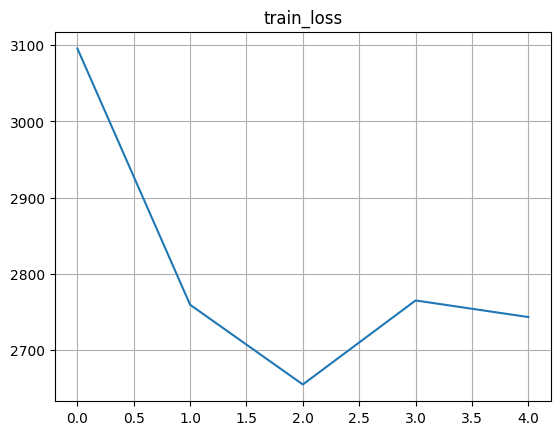

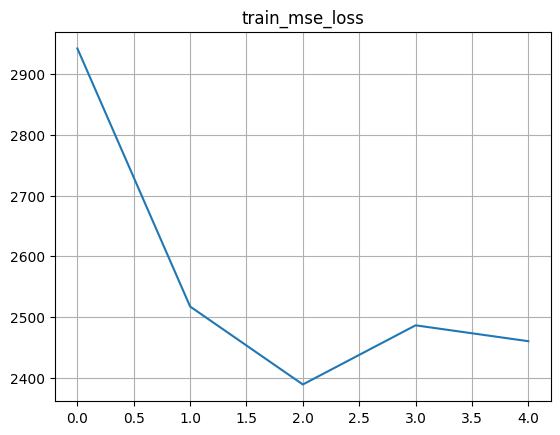

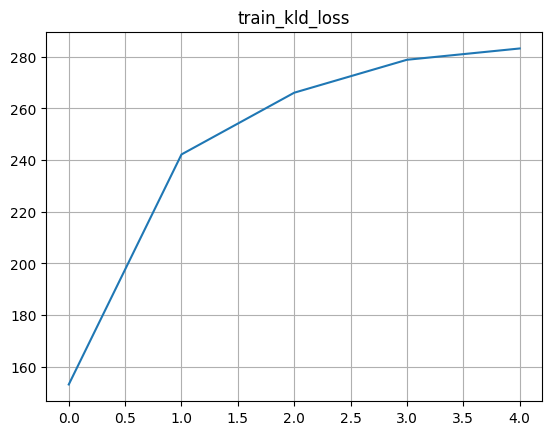

In [15]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss


loss_plots(loss_data, invidual_plots=True)

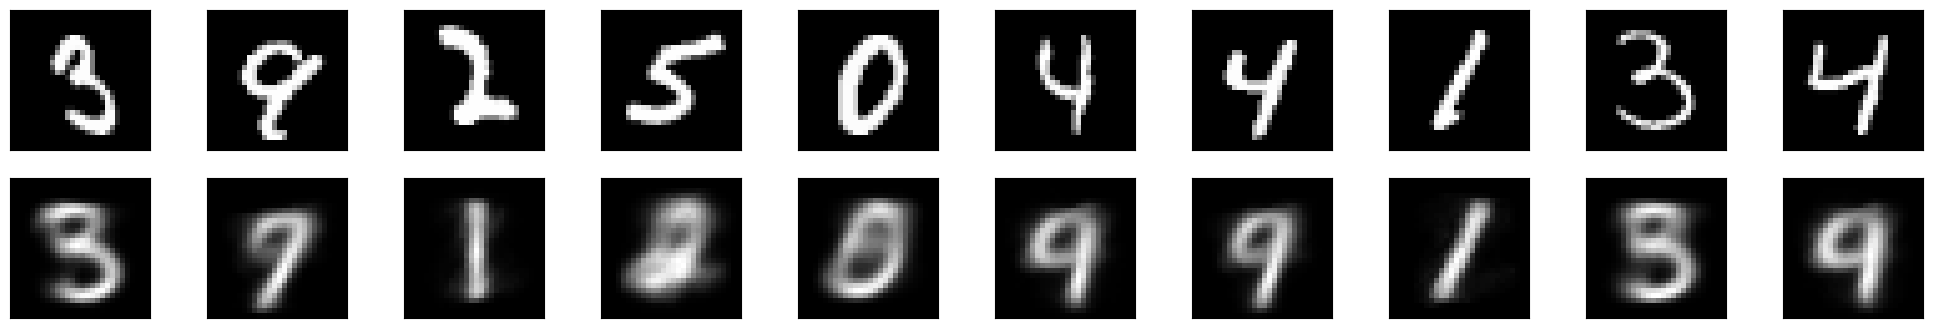

In [ ]:
# test the model
model.eval()

images, labels = next(iter(test_loader))

if cuda:
    images = images.cuda()
output = model(images)
x_hat, mu, sigma = output

# plot the original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, x_hat], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.cpu().detach().view(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

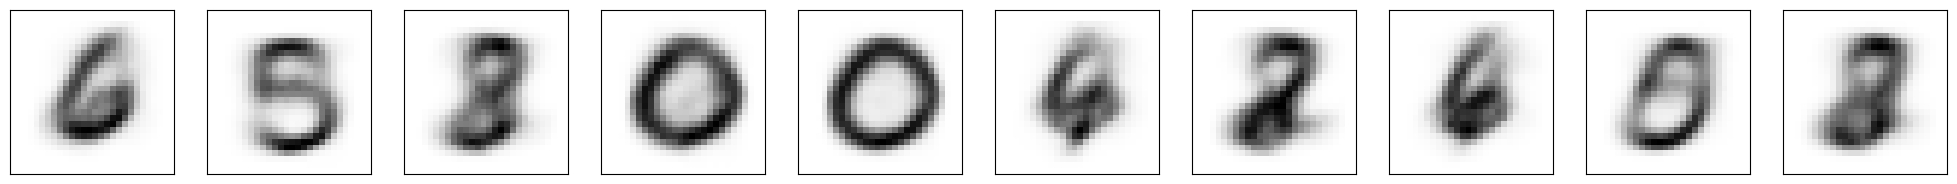

In [ ]:
# generate new images using decoder
with torch.no_grad():
    z = torch.randn(10, 2)
    if cuda:
        z = z.cuda()
    new_images = model.decoder(z)

fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for img, ax in zip(new_images, axes):
    ax.imshow(img.cpu().detach().view(28, 28), cmap='Greys')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [ ]:
class Inference:
    def __init__(self, model, num_samples=10):
        self.model = model
        self.model.eval()
        self.model.to('cpu')
        self.num_samples = num_samples
        self.digits = self.generate_digits(num_samples)

    # def __call__(self, x):
    #     if cuda:
    #         x = x.cuda()
    #     with torch.no_grad():
    #         x_hat, mu, logvar = self.model(x)
    #     return x_hat, mu, logvar
        
    def generate_digits(self, num_samples):
        digits = defaultdict(torch.Tensor)
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                # if cuda:
                #     batch_x = batch_x.cuda()
                x_hat, mu, sigma = self.model(batch_x)
                for x, y in zip(x_hat, batch_y):
                    if len(digits[y.item()]) < num_samples:
                        # add the generated image to the list
                        digits[y.item()] = torch.cat((digits[y.item()], x.unsqueeze(0)), dim=0)
                    else:
                        continue
                    
        return digits
    
inference = Inference(model)

In [ ]:
digits = inference.digits

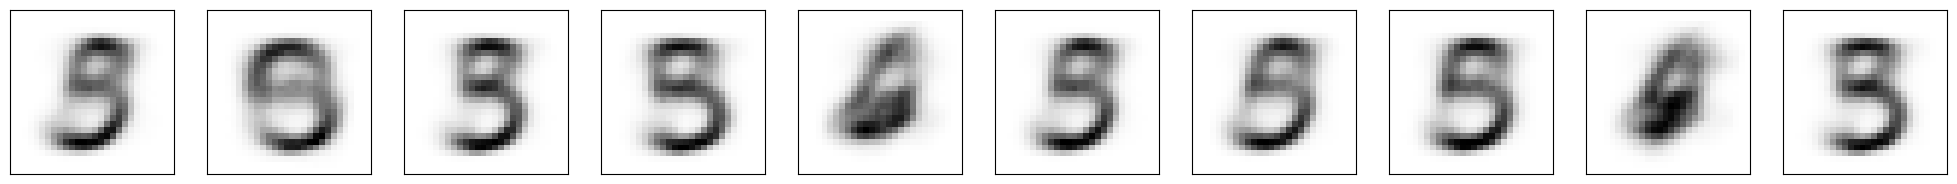

In [ ]:


fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for img, ax in zip(digits[5], axes):
    ax.imshow(img.view(28, 28), cmap='Greys')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)